In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [8]:
from KalmanNet import KalmanNet
from utils import generate_data, train
from Kalman import KalmanFilter
from LinearSystem import LinearSystem
from NonLinearSystem import NonlinearSystem

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


# Testcase 1: Lineární systém

In [ ]:
# --- Reálný systém ---
F_true = torch.tensor([[0.9]])
H_true = torch.tensor([[1.0]])
Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])
Ex0_true = torch.tensor([[1.0]])  # Očekávaná hodnota počátečního stavu
P0_true = torch.tensor([[2.0]])  # Počáteční kov

sys_true = LinearSystem(Ex0_true,P0_true,F_true, H_true, Q_true, R_true)

# nepřesný model (model mismatch)
F_model = torch.tensor([[0.8]])  # Horší odhad dynamiky
H_model = torch.tensor([[0.8]])
Q_model = torch.tensor([[0.2]])
R_model = torch.tensor([[0.05]])
Ex0_model = torch.tensor([[2.0]])  # Očekávaná hodnota počátečního stavu
P0_model = torch.tensor([[3.0]])  # Počáteční kov

sys_model = LinearSystem(Ex0_model,P0_model,F_model,H_model,Q_model,R_model) # Q a R neznáme


In [ ]:
# --- Generování dat ---
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200) # Jedna delší trajektorie pro test


In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# --- Použití klasického Kalmanova filtru pro srovnání ---
kalman_filter = KalmanFilter(Ex0_model, P0_model, F_model, H_model, Q_model, R_model)
kf_data = kalman_filter.apply_filter(y_test[0])
x_hat_kf = kf_data['x_filtered']

In [14]:
# --- Trénování modelu ---
knet = KalmanNet(sys_model).to(device)
train(knet, train_loader,device)

Zahajuji trénování KalmanNetu...
Epocha [10/50], Chyba (Loss): 0.061199
Epocha [20/50], Chyba (Loss): 0.065555
Epocha [30/50], Chyba (Loss): 0.065540
Epocha [40/50], Chyba (Loss): 0.065014
Epocha [50/50], Chyba (Loss): 0.060257
Trénování dokončeno.


In [15]:
# --- Evaluace a vizualizace ---
knet.eval()
with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_test_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_test_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
# x_hat_kf má tvar (seq_len, 1), musíme ho srovnat s x_test_batch[0]
mse_kf = mse_criterion(x_hat_kf, x_test[0])

print(f"\nVýsledná MSE KalmanNet: {mse_knet.item():.4f}")
print(f"Výsledná MSE klasického KF (nepřesný model): {mse_kf.item():.4f}")


Výsledná MSE KalmanNet: 0.0645
Výsledná MSE klasického KF (nepřesný model): 0.1181


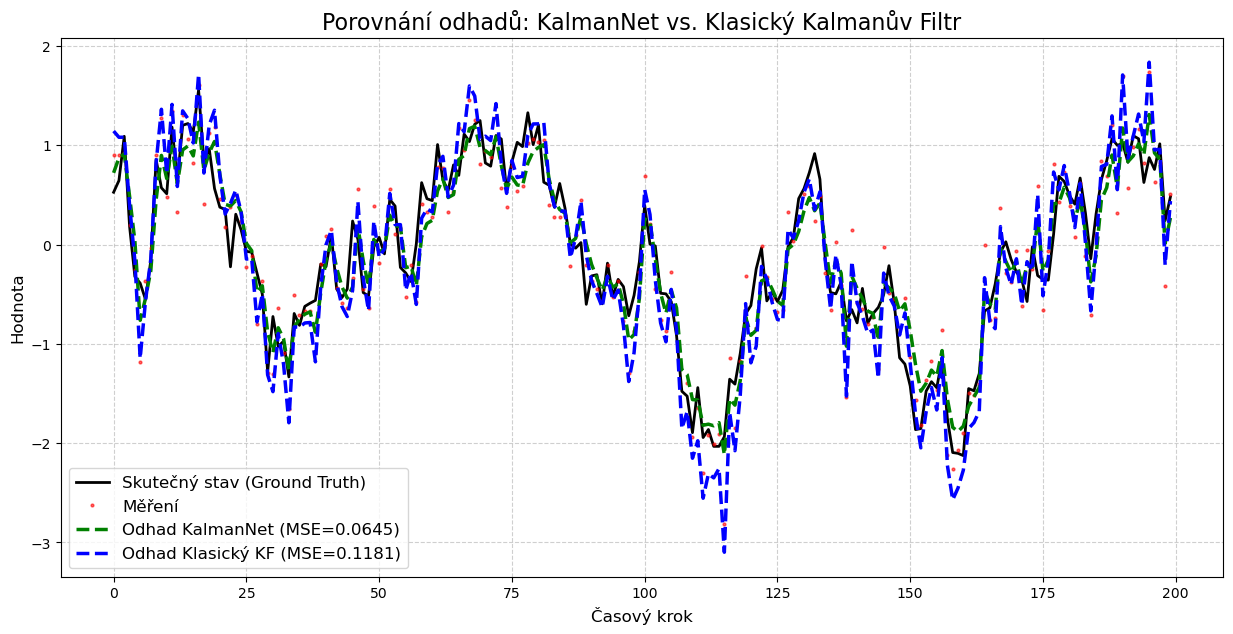

In [16]:
# --- 6. Vizualizace ---
plt.figure(figsize=(15, 7))
plt.title("Porovnání odhadů: KalmanNet vs. Klasický Kalmanův Filtr", fontsize=16)

# Získání dat pro plotting (odstranění zbytečných dimenzí)
x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_kf_plot = x_hat_kf.squeeze().numpy()

plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=4, alpha=0.6, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_kf_plot, 'b--', linewidth=2.5, label=f"Odhad Klasický KF (MSE={mse_kf.item():.4f})")

plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Testcase 2: Nelineární systém